# Setup Imports

In [54]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from userdefinedmodels import *

# Setup Location and Weather

In [55]:
# evaluate hood river, oregon and key west, florida

# latitude, longitude, name, altitude, timezone
hood_river = (45.71417626139969, -121.5154782530592, 'Hood River', 27, 'Etc/GMT+8')
latitude, longitude, name, altitude, timezone = hood_river

location = Location(
    latitude,
    longitude,
    name=name,
    altitude=altitude,
    tz=timezone,
    )

times = pd.date_range('2019-01-01 00:00', '2019-01-01 23:59', freq='1s', tz=location.tz)
weather = location.get_clearsky(times)



                           airmass_relative  airmass_absolute
2019-01-01 00:00:00-08:00               NaN               NaN
2019-01-01 00:00:01-08:00               NaN               NaN
2019-01-01 00:00:02-08:00               NaN               NaN
2019-01-01 00:00:03-08:00               NaN               NaN
2019-01-01 00:00:04-08:00               NaN               NaN
...                                     ...               ...
2019-01-01 23:58:56-08:00               NaN               NaN
2019-01-01 23:58:57-08:00               NaN               NaN
2019-01-01 23:58:58-08:00               NaN               NaN
2019-01-01 23:58:59-08:00               NaN               NaN
2019-01-01 23:59:00-08:00               NaN               NaN

[86341 rows x 2 columns]


## Sunrise Data

In [56]:
# Get the date
date = pd.Timestamp(times[0].date()).tz_localize(location.tz)

# Create a DatetimeIndex with the single date
times_single_day = pd.DatetimeIndex([date])

# Get sunrise, sunset, and transit times for the date
result = location.get_sun_rise_set_transit(times_single_day)

# Print the sunrise time
print(type(result))

# Get sunrise, sunset, and transit times from the DataFrame
sunrise = result['sunrise'].iloc[0]
sunset = result['sunset'].iloc[0]
transit = result['transit'].iloc[0]

# Print the sunrise time
print(sunrise)


<class 'pandas.core.frame.DataFrame'>
2019-01-01 07:46:30.877973-08:00


# Setup System

## Module Parameters

In [57]:
# Get the module parameters from the CEC database
MODULE_24 = pvlib.pvsystem.retrieve_sam('CECMod')['JA_Solar_JAM5_L__72_200_SI']

# Create a dictionary of the parameters to represent the 12V Rich Solar module
# Scale the paremters that can be easily scaled
rich_solar_12V_params = {
    'Name' : 'Rich Solar 12V',
    'Technology': MODULE_24['Technology'],
    'Bifacial' : MODULE_24['Bifacial'],
    'STC' : MODULE_24['STC'],
    'PTC' : MODULE_24['PTC'],
    'A_c' : MODULE_24['A_c']*2,
    'Length' : MODULE_24['Length'],
    'Width' : MODULE_24['Width'],
    'N_s' : MODULE_24['N_s']/2,
    'I_sc_ref' : MODULE_24['I_sc_ref']*2,
    'V_oc_ref' : MODULE_24['V_oc_ref']/2,
    'I_mp_ref' : MODULE_24['I_mp_ref']*2,
    'V_mp_ref' : MODULE_24['V_mp_ref']/2,
    'alpha_sc' : MODULE_24['alpha_sc']*2,
    'beta_oc' : MODULE_24['beta_oc']/2,
    'gamma_r' : MODULE_24['gamma_r'],
    'T_NOCT' : MODULE_24['T_NOCT'],
}

# Caculate the remaining parameters for the 12V module
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = pvlib.ivtools.sdm.fit_cec_sam(
                                                                         celltype='monoSi',
                                                                         v_mp=rich_solar_12V_params['V_mp_ref'],
                                                                         i_mp=rich_solar_12V_params['I_mp_ref'],
                                                                         v_oc=rich_solar_12V_params['V_oc_ref'],
                                                                         i_sc=rich_solar_12V_params['I_sc_ref'],
                                                                         alpha_sc=rich_solar_12V_params['alpha_sc'],
                                                                         beta_voc=rich_solar_12V_params['beta_oc'],
                                                                         gamma_pmp=rich_solar_12V_params['gamma_r'],
                                                                         cells_in_series=rich_solar_12V_params['N_s']
                                                                         )

# Add the calculated parameters to the dictionary representing the 12V Rich Solar module
rich_solar_12V_params['a_ref'] = a_ref
rich_solar_12V_params['I_L_ref'] = I_L_ref
rich_solar_12V_params['I_o_ref'] = I_o_ref
rich_solar_12V_params['R_s'] = R_s
rich_solar_12V_params['R_sh_ref'] = R_sh_ref
rich_solar_12V_params['Adjust'] = Adjust

## Temperature Parameters

In [58]:
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']


## Inverter Parameters
`v_batt`, `v_start`, `v_continue`, `r_batt_wire`, and `r_pv_wire`, are passed in a dict-like object via the PVSystem kwarg `inverter_parameters`.  

In [59]:
# Assume 20 ft of 10AGW wire on PV Side
r_batt_wire = getWireResistance('10AWG', 20)
# Assume 10 ft 10AGW wire on Battery Side
r_pv_wire = getWireResistance('10AWG', 20)

mppt_parameters = {
    'v_batt': 14.2,
    'v_start_delta': 5.0,
    'v_continue_delta': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': 0.99
}

v_batt:  14.2
v_start_delta:  5.0
v_continue_delta:  1.0
v_start:  19.2
v_continue:  15.2


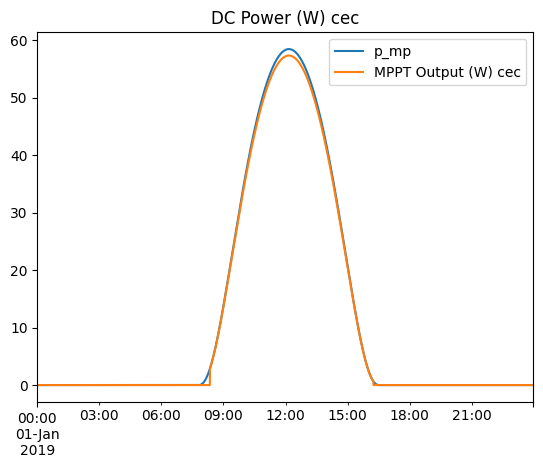

In [60]:

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
array = Array(
    mount=mount,
    module_parameters=rich_solar_12V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=1,
    modules_per_string=1,
    )

system = PVSystem(arrays=[array], 
                  inverter_parameters=mppt_parameters)

mc = ModelChain(system, 
                location, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="cec",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )





mc.run_model(weather)
    
#plot
plt.figure()
mc.results.dc['p_mp'].plot(title='DC Power (W) cec')
mc.results.ac.plot(label='MPPT Output (W) cec')
plt.legend()


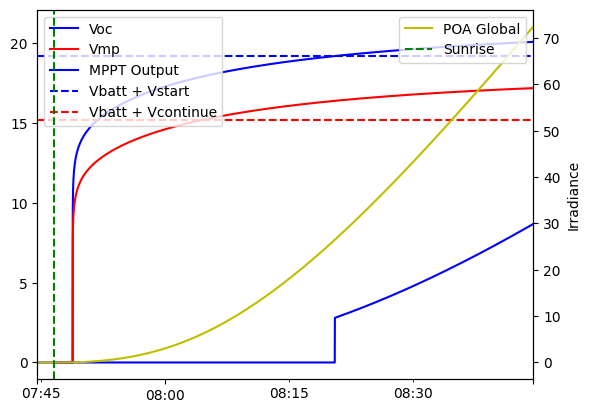

<Axes: >

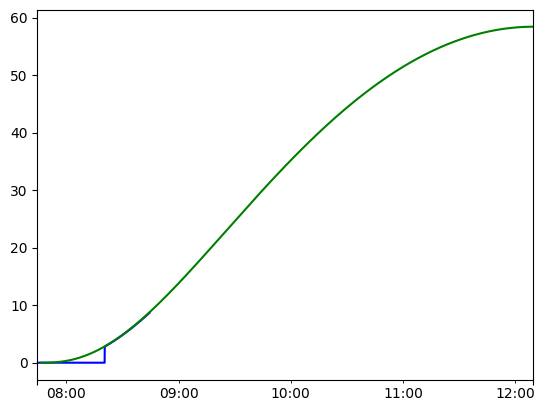

In [66]:
# Create a time delta of 15 minutes
delta = pd.Timedelta(minutes=58)
offset = pd.Timedelta(minutes=2)

# Calculate the start and end of the range
#start = sunrise + offset - delta
#end = sunrise 
start = sunrise - offset
end = sunrise + delta

# Slice the DataFrame
irr_slice = mc.results.total_irrad.loc[start:end]
ac_slice = mc.results.ac.loc[start:end]

# Create a plot of the sliced DataFrame
fig, ax = plt.subplots()

# Plot v_oc and v_mp with specified colors and labels
dc_slice['v_oc'].plot(ax=ax, color='b', label='Voc')
dc_slice['v_mp'].plot(ax=ax, color='r', label='Vmp')
ac_slice.plot(ax=ax, color='b', label='MPPT Output')


# Create a second Axes object that shares the x-axis with the first
ax2 = ax.twinx()


# Plot the irradiance data on the second Axes object with a specified color and label
irr_slice['poa_global'].plot(ax=ax2, color='y', label='POA Global')
#irr_slice['poa_direct'].plot(ax=ax2, color='m', label='POA Direct')
#irr_slice['poa_diffuse'].plot(ax=ax2, color='g', label='POA Difuse')

# Plot a vertical line at sunrise with a specified label
ax2.axvline(sunrise, color='g', linestyle='--', label='Sunrise')

# Plot a horizontal line at v_batt + v_start with a specified label
ax.axhline(mppt_parameters['v_batt'] + mppt_parameters['v_start_delta'], color='b', linestyle='--', label='Vbatt + Vstart')

# Plot a horizontal line at v_batt + v_continue with a specified label
ax.axhline(mppt_parameters['v_batt'] + mppt_parameters['v_continue_delta'], color='r', linestyle='--', label='Vbatt + Vcontinue')

# Add a label to the second y-axis
ax2.set_ylabel('Irradiance')

# Add a legend to each Axes
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

plt.figure()

ac_slice.plot(color='b', label='MPPT Output')
dc_slice['p_mp'].plot(color='g', label='Pmp')

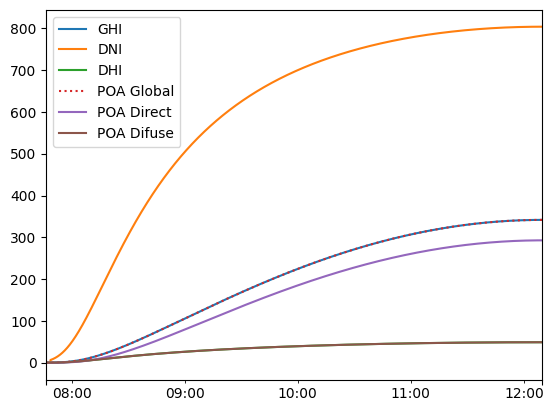

In [62]:
weather_slice = weather.loc[start:end]
weather_slice['ghi'].plot(label='GHI')
weather_slice['dni'].plot(label='DNI')
weather_slice['dhi'].plot(label='DHI')
irr_slice['poa_global'].plot(linestyle=':', label='POA Global')
irr_slice['poa_direct'].plot(label='POA Direct')
irr_slice['poa_diffuse'].plot(label='POA Difuse')
plt.legend()

Direct Normal Irradiation (DNI) is the amount of solar radiation received per unit area by a surface that is always held perpendicular (or normal) to the rays that come in a straight line from the direction of the sun at its current position in the sky.

